In [25]:
using HDF5, AeroAcoustics, PyPlot

## 1. Quick start

In [2]:
csm_file = joinpath(dirname(@__DIR__),"test","data","test1_csm.h5")
csm_ref = h5open(csm_file, "r") do file
    read(file, "CsmData/csmReal")+im*read(file, "CsmData/csmImag")
end
fc = h5read(csm_file, "CsmData")["binCenterFrequenciesHz"]
micgeom = h5read(csm_file, "CsmData")["arrayGeom"]
z0 = h5readattr(csm_file, "CsmData")["z0"]

1.6

In [3]:
CSM = FreqArray(csm_ref,fc);

In [4]:
E = Environment(
    z0=z0,
    micgeom=micgeom,
    CSM=CSM,
    flim=(3000,4000),
    Nx = 21,
    Ny = 21,
    xlim=(-0.5,0.5),
    ylim=(-0.5,0.5)
    );

In [5]:
steeringvectors!(E)

In [98]:
b = beamforming(E);

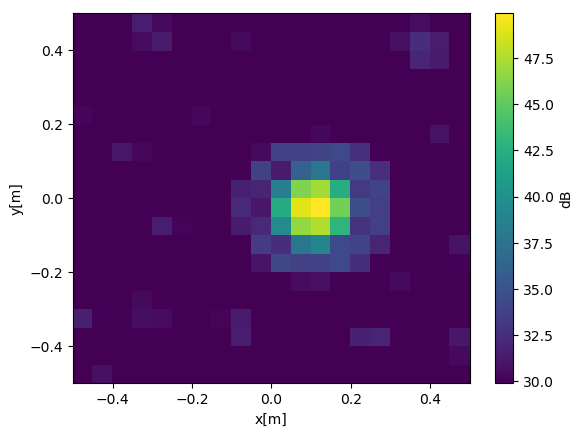

In [99]:
b_img = reshape(b[:,1],E.Nx,E.Ny)
bdB = SPL.(b_img)
maxdB = maximum(filter(!isnan,bdB))
pcolormesh(E.rx,E.ry,bdB,vmax=maxdB,vmin=maxdB-20)
xlabel("x[m]")
ylabel("y[m]")
cbar = colorbar()
cbar.set_label("dB")

In [100]:
src_pos_ind = findmax(bdB)[2]
src_pos = E.rx[src_pos_ind[2]],E.ry[src_pos_ind[1]]

(0.1, -0.05)

## 2. Clean-sc

In [101]:
@time xSC = cleanSC(E);

  2.328783 seconds (39.32 k allocations: 740.932 MiB, 7.68% gc time)


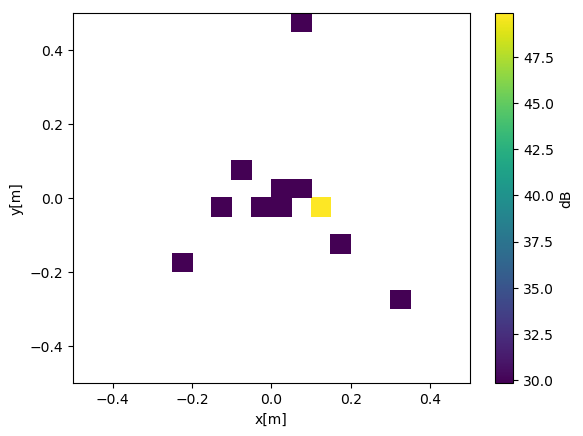

In [102]:
clean_img = reshape(xSC[:,1],E.Nx,E.Ny)
clean_dB = SPL.(clean_img)
maxdB = maximum(filter(!isnan,clean_dB))
pcolormesh(E.rx,E.ry,clean_dB,vmax=maxdB-20,vmin=maxdB)
xlabel("x[m]")
ylabel("y[m]")
cbar = colorbar()
cbar.set_label("dB")

## 3. DAMAS

In [103]:
@time xD = damas(E,b;maxiter = 50);

  1.833264 seconds (176.50 k allocations: 1.188 GiB, 13.15% gc time)


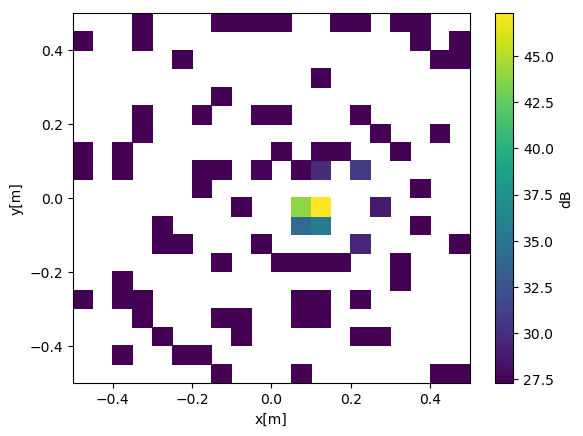

In [104]:
damas_img = reshape(xD[:,1],E.Nx,E.Ny)
damas_dB = SPL.(damas_img)
maxdB = maximum(filter(!isnan,damas_dB))
pcolormesh(E.rx,E.ry,damas_dB,vmax=maxdB-20,vmin=maxdB)
xlabel("x[m]")
ylabel("y[m]")
cbar = colorbar()
cbar.set_label("dB")

## 4. Source integration

In [105]:
dxdy = (0.5,0.5)
int_region = AeroAcoustics.point_to_region(src_pos,dxdy)
b_srcint = sourceintegration(b,E,int_region)
clean_srcint = sourceintegration(xSC,E,int_region)
damas_srcint = sourceintegration(xD,E,int_region);

In [106]:
["beamforming" "Clean-SC" "damas"; SPL.([b_srcint clean_srcint damas_srcint])]

5×3 Matrix{Any}:
   "beamforming"    "Clean-SC"    "damas"
 57.6716          49.903        49.6277
 58.728           51.2255       51.2962
 62.6049          55.8159       55.8473
 60.905           54.7118       54.8137

Note that the standard beamforming result do not yield a correct source power. Therefore we need to normalize the beamforming image with the point spread function (psf). This is called source power integration (SPI). A convenience function `SPI` is supplied to make this normalization:

In [107]:
SPI_srcint = SPI(b,E,dxdy,int_region);

In [108]:
["beamforming" "SPI" "Clean-SC" "damas"; SPL.([b_srcint SPI_srcint clean_srcint damas_srcint])]

5×4 Matrix{Any}:
   "beamforming"    "SPI"    "Clean-SC"    "damas"
 57.6716          49.167   49.903        49.6277
 58.728           50.8748  51.2255       51.2962
 62.6049          55.3492  55.8159       55.8473
 60.905           54.1891  54.7118       54.8137

The three methods `SPI`, `Clean-SC`, and `DAMAS` now return very similar results of the source power for the 4 frequency bins defined in the environment (3000-4000 Hz).